# Prevendo valor das Ações da Petrobrás (PETR4)

Notebook criado durante a Live da PósTech de Data Science da FIAP, com o objetivo de prever o valor das ações da Petrobrás (PETR4) utilizando MA, ARIMA, Prophet e LSTM.

In [1]:
# Biliotecas padrão
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

sns.set_theme(style="darkgrid")

# Bibliotecas para obter dados
import yfinance as yf

# Bibliotecas modelo ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Bibliotecas para LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Bibliotecas para ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Biblioteca para Prophet
from prophet import Prophet


/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregando dados

In [2]:
symbol = "PETR4.SA"
start_date = "2018-01-01"
end_date = "2023-12-21"

df_pandas = yf.download(symbol, start=start_date, end=end_date)
df_raw = pl.from_pandas(df_pandas.reset_index())


[*********************100%%**********************]  1 of 1 completed


In [3]:
# Verificando dados
df_raw.tail(5)

Date,Open,High,Low,Close,Adj Close,Volume
datetime[ns],f64,f64,f64,f64,f64,i64
2023-12-14 00:00:00,35.0,35.740002,34.84,35.32,35.32,57950000
2023-12-15 00:00:00,35.279999,35.790001,35.0,35.400002,35.400002,56570100
2023-12-18 00:00:00,35.75,36.299999,35.580002,35.84,35.84,44474300
2023-12-19 00:00:00,35.959999,36.25,35.810001,36.25,36.25,32183000
2023-12-20 00:00:00,36.369999,36.740002,36.290001,36.380001,36.380001,38947900


In [4]:
df_raw.shape

(1482, 7)

In [5]:
# Criando cópia do dataframe
df_petr4 = df_raw.clone()

## Conhecendo os Dados

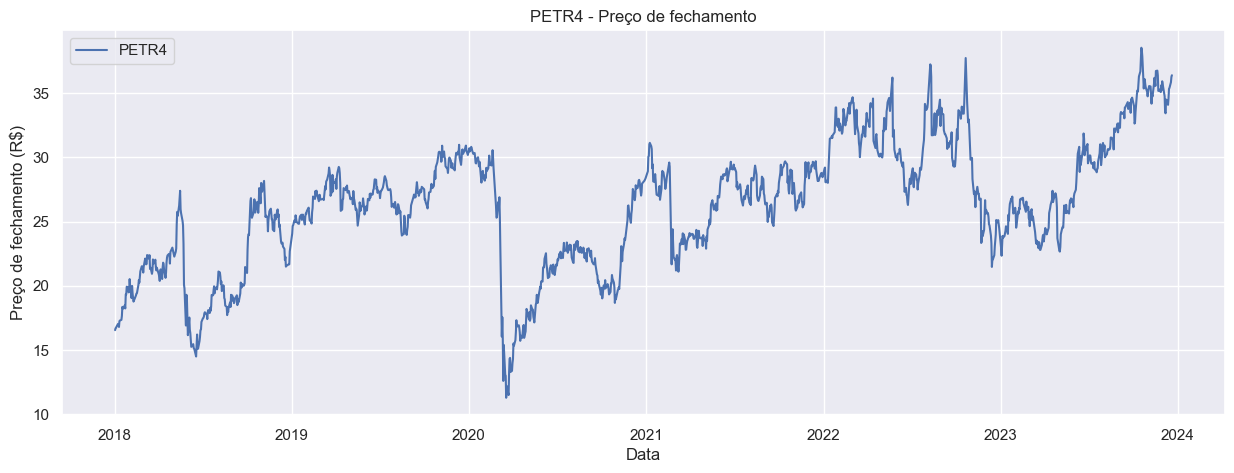

In [6]:
plt.figure(figsize=(15, 5))

sns.lineplot(data=df_petr4, x="Date", y="Close", label="PETR4")
plt.title("PETR4 - Preço de fechamento")
plt.ylabel("Preço de fechamento (R$)")
plt.xlabel("Data")
plt.show()

### Análise da Série Temporal

Vamos decompor a série temporal para entendermos melhor os dados. Decomposição é uma técnica que permite separar uma série temporal em três componentes: tendência, sazonalidade e ruído.

A decomposição nos ajudará a identificar se a série é aditiva ou multiplicativa. Uma série aditiva é aquela em que os componentes acima são adicionados. Se a série for multiplicativa, os componentes serão multiplicados.

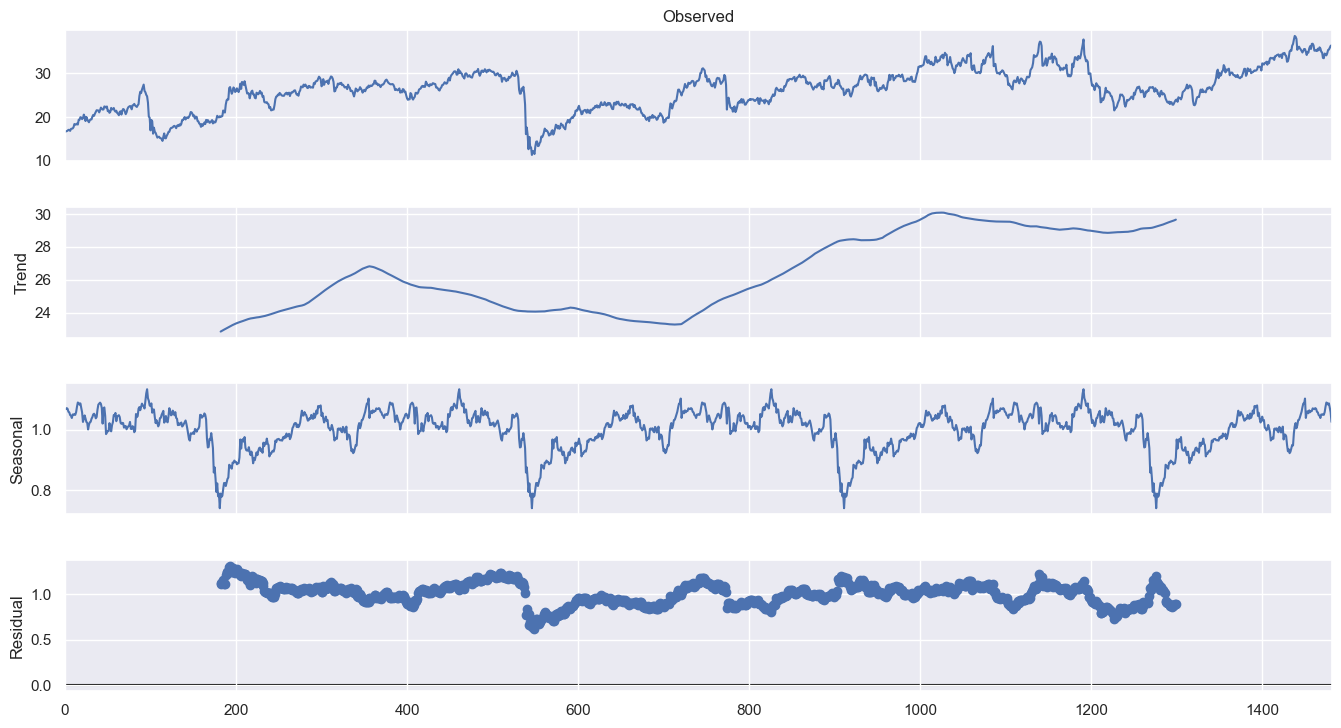

In [7]:
(
    seasonal_decompose(
        df_petr4[['Close']], 
        model="multiplicative", 
        period=365
    )
    .plot()
    .set_size_inches(15, 8)
)

## Modelo de Média Móvel (MA)

O modelo de média móvel (MA) é um modelo de séries temporais que extrai a tendência de uma série temporal com base em erros de previsão anteriores. O modelo de média móvel é uma abordagem ingênua para prever valores futuros. Ele simplesmente calcula a média dos valores anteriores e usa isso como a previsão para valores futuros.

In [8]:
df_ma = (
    df_petr4.select(
        pl.col(['Date', 'Close'])
    )
    .with_columns(
        pl.col('Close').rolling_mean(10).alias('MA10'),
        pl.col('Close').rolling_mean(20).alias('MA20'),
    )
)

df_ma.head(20)

Date,Close,MA10,MA20
datetime[ns],f64,f64,f64
2018-01-02 00:00:00,16.549999,null,null
2018-01-03 00:00:00,16.700001,null,null
2018-01-04 00:00:00,16.73,null,null
2018-01-05 00:00:00,16.83,null,null
2018-01-08 00:00:00,17.030001,null,null
2018-01-09 00:00:00,17.030001,null,null
2018-01-10 00:00:00,16.799999,null,null
2018-01-11 00:00:00,17.25,null,null
2018-01-12 00:00:00,17.299999,null,null


Visualizando a série temporal com a média móvel.

Text(0.5, 0, 'Data')

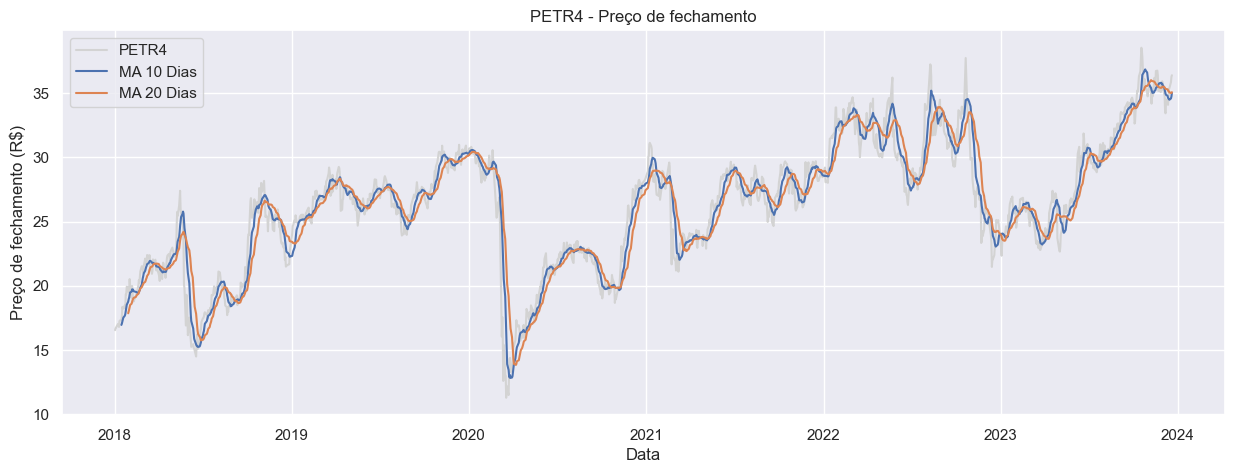

In [9]:
plt.figure(figsize=(15, 5))

sns.lineplot(data=df_ma, x="Date", y="Close", label="PETR4", color="lightgray")
sns.lineplot(data=df_ma, x="Date", y="MA10", label="MA 10 Dias")
sns.lineplot(data=df_ma, x="Date", y="MA20", label="MA 20 Dias")

plt.title("PETR4 - Preço de fechamento")
plt.ylabel("Preço de fechamento (R$)")
plt.xlabel("Data")

Filtrando para exibir apenas os dados de 2023

Text(0.5, 0, 'Data')

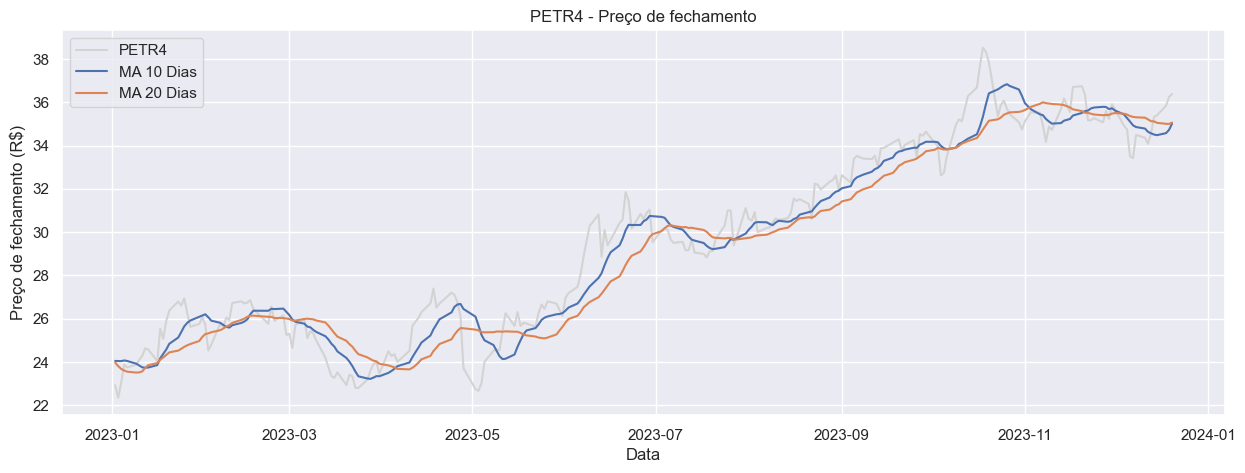

In [10]:
df_aux = df_ma.filter(pl.col('Date') >= pl.date(2023, 1, 1))

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_aux, x="Date", y="Close", label="PETR4", color="lightgray")
sns.lineplot(data=df_aux, x="Date", y="MA10", label="MA 10 Dias")
sns.lineplot(data=df_aux, x="Date", y="MA20", label="MA 20 Dias")

plt.title("PETR4 - Preço de fechamento")
plt.ylabel("Preço de fechamento (R$)")
plt.xlabel("Data")

Vamos prever os próximos 10 dias com base apenas na média móvel.

In [11]:
df_ma = df_ma.with_columns(
    pl.lit(None).alias('MA10_FWD10')
)

In [12]:
def make_window(window_size, start_point):
    return [start_point + i for i in range(window_size)]

In [13]:
df_aux = df_ma.to_pandas().set_index('Date')

In [14]:
window_size = 10
forward_days = 10

for index in range(window_size, len(df_ma), forward_days):
    
    for i in range(0, forward_days):
        if index+i >= len(df_ma):
            break

        window_close = make_window(window_size - i, index+i-window_size)
        window_ma = make_window(i, index)

        mean = pd.concat([
            df_aux['Close'].iloc[window_close],
            df_aux['MA10_FWD10'].iloc[window_ma]
        ]).mean(axis=0)

        df_aux.iat[index + i, df_aux.columns.get_loc('MA10_FWD10')] = mean

/var/folders/6x/3y02z1591rj130ytmr_hv8nh0000gn/T/ipykernel_33988/4103718532.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  mean = pd.concat([


Plotando o gráfico com a previsão

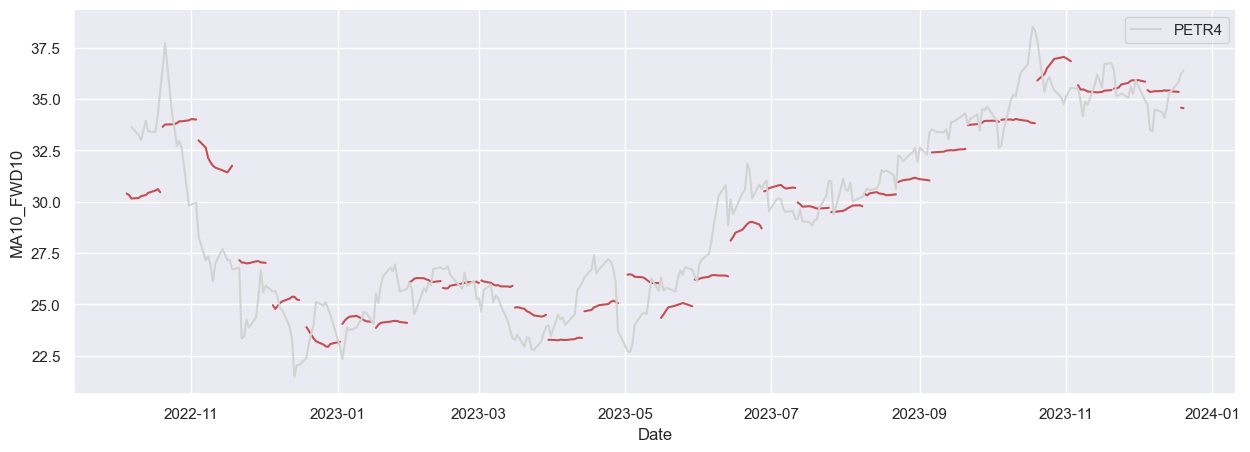

In [15]:
limit = 300
plt.figure(figsize=(15, 5))

size = len(df_aux) - limit - (len(df_aux) - limit) % forward_days

for index in range(size, len(df_aux), forward_days):
    sns.lineplot(
        data=df_aux.iloc[index:index+forward_days], 
        x="Date", 
        y="MA10_FWD10", 
        color='r'
    )

sns.lineplot(data=df_aux[-limit:], x="Date", y="Close", label="PETR4", color="lightgray");

## Modelo ARIMA

ARIMA significa Média Móvel Integrada Auto-Regressiva. É um modelo estatístico usado para analisar e prever pontos de dados, enquanto leva em consideração o comportamento de toda a série temporal.

O modelo ARIMA é composto por três partes: AR (Auto-Regressão), I (Integração) e MA (Média Móvel). Cada parte é responsável por diferentes aspectos da série temporal.

O termo Auto-Regressão (AR) refere-se a um modelo de regressão que utiliza variáveis dependentes atrasadas. A Integração (I) refere-se à diferença não sazonal, ou seja, a diferença entre observações consecutivas na série temporal. A Média Móvel (MA) refere-se a um modelo de regressão que utiliza erros de previsão anteriores em um modelo de regressão.

**ARIMA(p,d,q)**

* p: ordem do modelo AR (Auto-Regressão). Número de lags que serão incluídos no modelo, também conhecido como lag order.
* d: ordem de integração da série temporal. Número de vezes que a série temporal precisa ser diferenciada para torná-la estacionária.
* q: ordem do modelo MA (Média Móvel). Número de erros de previsão que serão incluídos no modelo, também conhecido como ordem de média móvel.

### Correlação dos dados

A autocorrelação é uma medida de correlação entre uma série temporal e uma versão atrasada de si mesma. Por exemplo, uma autocorrelação de ordem 3 retorna a correlação entre uma série temporal e sua versão atrasada em 3 períodos de tempo.

Para visualizar a autocorrelação, podemos usar o gráfico de autocorrelação (ACF) e o gráfico de autocorrelação parcial (PACF).

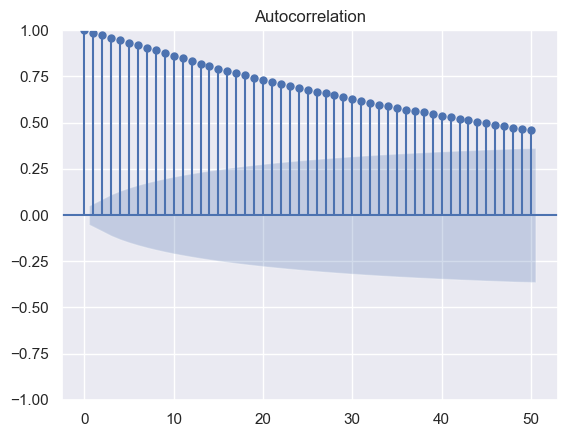

In [16]:
sm.graphics.tsa.plot_acf(df_petr4['Close'], lags=50);

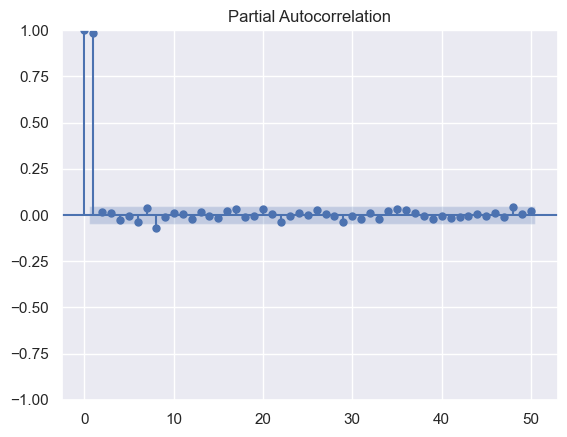

In [17]:
sm.graphics.tsa.plot_pacf(df_petr4['Close'], lags=50);

### Analisando a Média Móvel (MA)

In [18]:
df_aux = df_petr4.select(
    pl.col('Date'), 
    pl.col('Close')
).with_columns(
    pl.col('Close').rolling_mean(30).alias('MA'),
    pl.col('Close').rolling_std(30).alias('STD'),
)

df_aux.head()

Date,Close,MA,STD
datetime[ns],f64,f64,f64
2018-01-02 00:00:00,16.549999,null,null
2018-01-03 00:00:00,16.700001,null,null
2018-01-04 00:00:00,16.73,null,null
2018-01-05 00:00:00,16.83,null,null
2018-01-08 00:00:00,17.030001,null,null


Text(0.5, 0, 'Data')

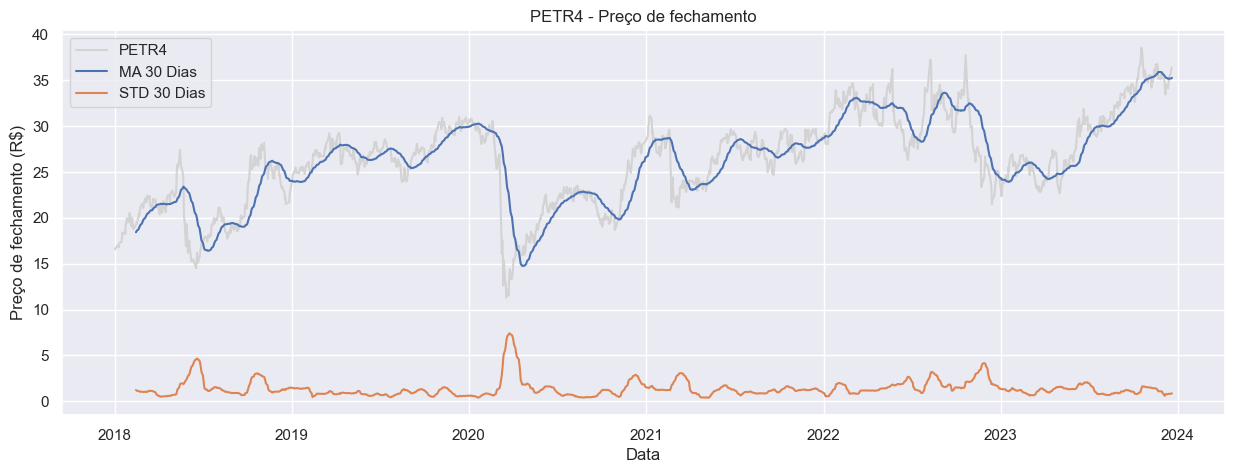

In [19]:
plt.figure(figsize=(15, 5))

sns.lineplot(data=df_aux, x="Date", y="Close", label="PETR4", color="lightgray")
sns.lineplot(data=df_aux, x="Date", y="MA", label="MA 30 Dias")
sns.lineplot(data=df_aux, x="Date", y="STD", label="STD 30 Dias")

plt.title("PETR4 - Preço de fechamento")
plt.ylabel("Preço de fechamento (R$)")
plt.xlabel("Data")

O Desvio Padrão Móvel (MSD) é uma medida do qual variável é a série temporal. Em uma série temporal estacionária, o desvio padrão móvel deve ser constante ao longo do tempo.

### Analisando a Estacionariedade

O teste de Dickey-Fuller aumentado (ADF) é um teste estatístico que pode ser usado para testar a estacionariedade. Nele, a hipótese nula (H0) é que a série temporal não é estacionária. Portanto, se o valor-p do teste for menor que o nível de significância (0,05), rejeitamos a hipótese nula e inferimos que a série temporal é estacionária.

In [20]:
adf_result = adfuller(df_petr4['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

if adf_result[1] > 0.05:
    print('Série não estacionária')
else:
    print('Série estacionária')

ADF Statistic: -3.080591482727137
p-value: 0.028023246893662587
Critical Values:
	1%: -3.4347941822385923
	5%: -2.863502816068378
	10%: -2.5678149835134185
Série estacionária


Apesar do teste de Dickey-Fuller ter dado um valor-p menor que 0,05, vamos aplicar a diferenciação e outras técnicas para garantir que a série temporal seja estacionária.

In [21]:
df_arima = df_petr4.select(
    pl.col('Date'), 
    pl.col('Close')
)

#### Subtrair os dados transformados pelo log pela média móvel

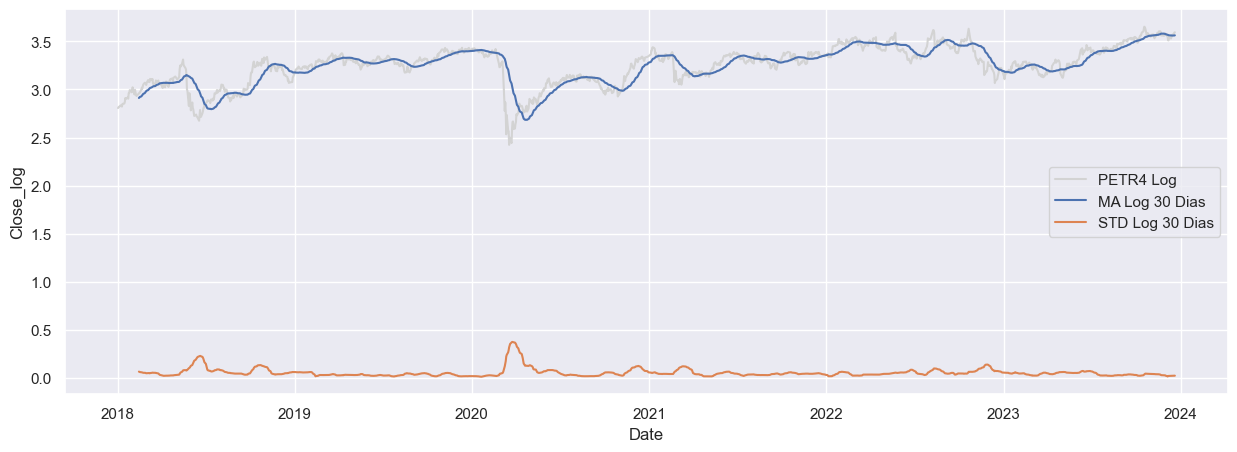

In [22]:
df_aux = df_arima.with_columns(
    pl.col('Close').log().alias('Close_log')
).with_columns(
    pl.col('Close_log').rolling_mean(30).alias('Close_log_MA'),
    pl.col('Close_log').rolling_std(30).alias('Close_log_STD'),
)

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_aux, x="Date", y="Close_log", label="PETR4 Log", color="lightgray");
sns.lineplot(data=df_aux, x="Date", y="Close_log_MA", label="MA Log 30 Dias");
sns.lineplot(data=df_aux, x="Date", y="Close_log_STD", label="STD Log 30 Dias");

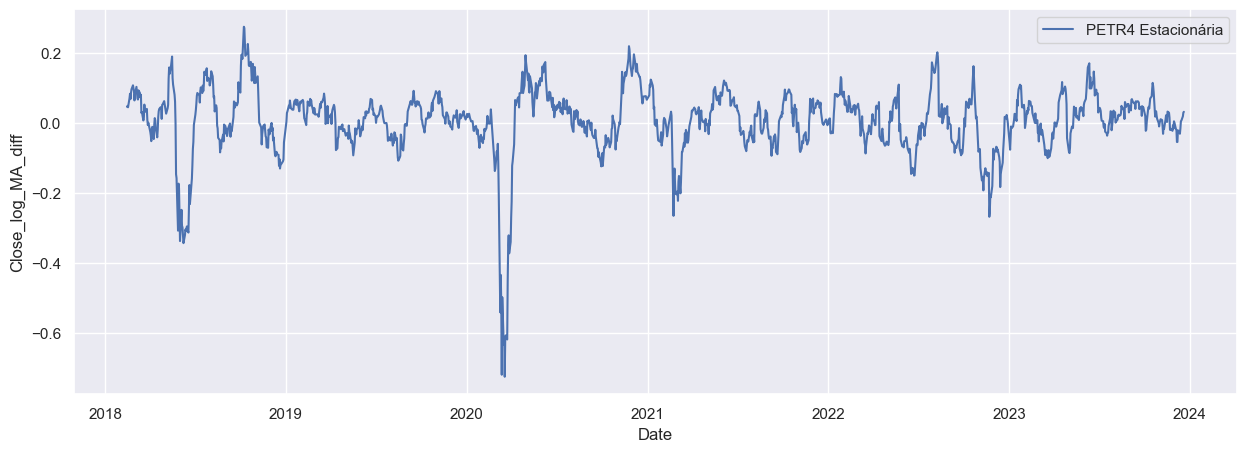

In [23]:
df_aux = df_aux.with_columns(
    (pl.col('Close_log') - pl.col('Close_log_MA')).alias('Close_log_MA_diff')
).drop_nulls()

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_aux, x="Date", y="Close_log_MA_diff", label="PETR4 Estacionária");

In [24]:
adf_result = adfuller(df_aux['Close_log_MA_diff'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

if adf_result[1] > 0.05:
    print('Série não estacionária')
else:
    print('Série estacionária')

ADF Statistic: -7.958038087656618
p-value: 3.000314810094936e-12
Critical Values:
	1%: -3.4348835326305642
	5%: -2.863542248636555
	10%: -2.5678359819686065
Série estacionária


#### Decaimento exponencial

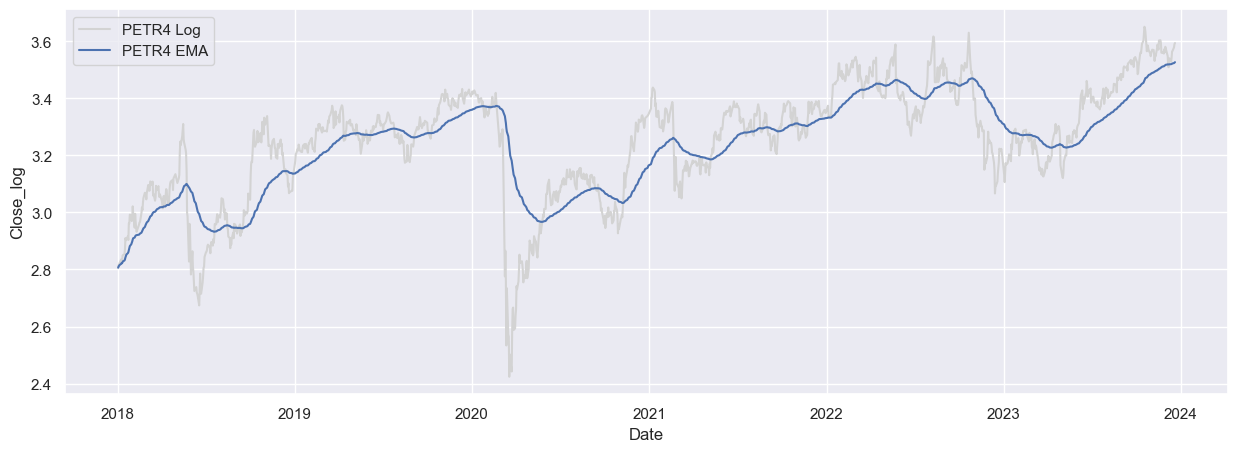

In [25]:
df_aux = (
    df_arima.with_columns(
        pl.col('Close').log().alias('Close_log')
    )
    .with_columns(
        pl.col('Close_log').ewm_mean(half_life=30, min_periods=0).alias('Close_log_EMA')
    )
)

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_aux, x="Date", y="Close_log", label="PETR4 Log", color="lightgray");
sns.lineplot(data=df_aux, x="Date", y="Close_log_EMA", label="PETR4 EMA");

In [26]:
adf_result = adfuller(df_aux['Close_log_EMA'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

if adf_result[1] > 0.05:
    print('Série não estacionária')
else:
    print('Série estacionária')

ADF Statistic: -2.249886939685341
p-value: 0.18863982549865455
Critical Values:
	1%: -3.4347972046167983
	5%: -2.863504149938827
	10%: -2.567815693817062
Série não estacionária


#### Diferenciação

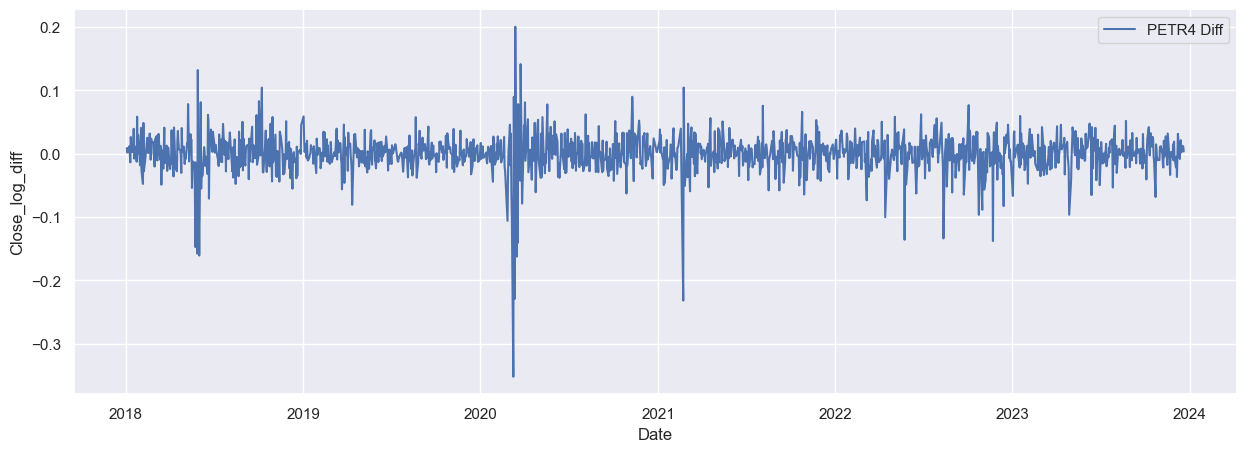

In [27]:
df_aux = (
    df_arima.with_columns(
        pl.col('Close').log().alias('Close_log')
    )
    .with_columns(
        pl.col('Close_log').diff().alias('Close_log_diff')
    ).drop_nulls()
)

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_aux, x="Date", y="Close_log_diff", label="PETR4 Diff");

In [28]:
adf_result = adfuller(df_aux['Close_log_diff'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

if adf_result[1] > 0.05:
    print('Série não estacionária')
else:
    print('Série estacionária')

ADF Statistic: -12.49433633624208
p-value: 2.898565611188143e-23
Critical Values:
	1%: -3.4347941822385923
	5%: -2.863502816068378
	10%: -2.5678149835134185
Série estacionária


In [29]:
df_arima = df_aux.clone()

### Teste de Correlação

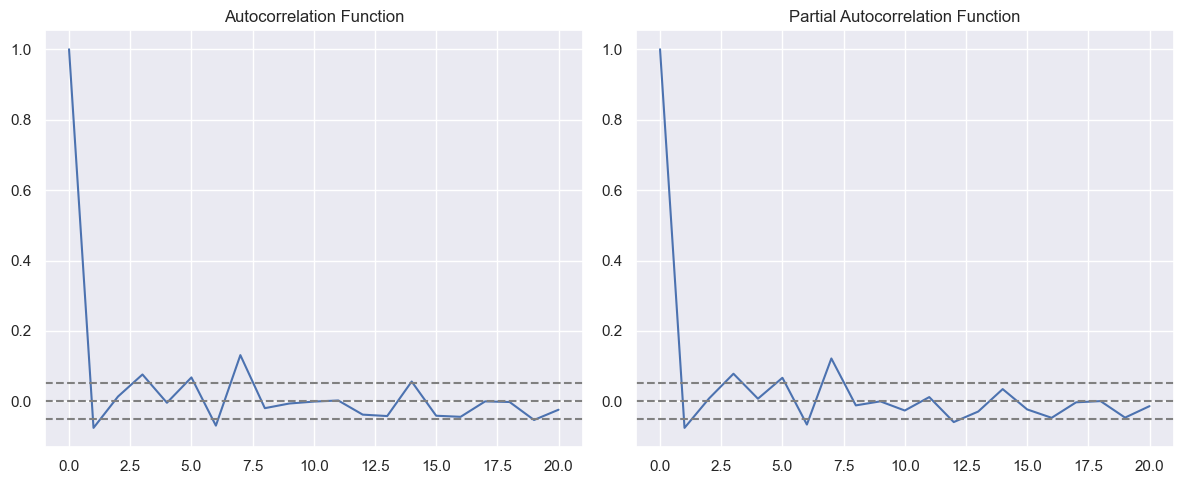

In [30]:
lag_acf = acf(df_arima['Close_log_diff'], nlags=20)
lag_pacf = pacf(df_arima['Close_log_diff'], nlags=20, method='ols')

plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.lineplot(x=range(len(lag_acf)), y=lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_arima['Close_log_diff'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_arima['Close_log_diff'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
sns.lineplot(x=range(len(lag_pacf)), y=lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_arima['Close_log_diff'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_arima['Close_log_diff'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()


### Treinando o Modelo ARIMA

/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'ARIMA - RSS: 1.5641')

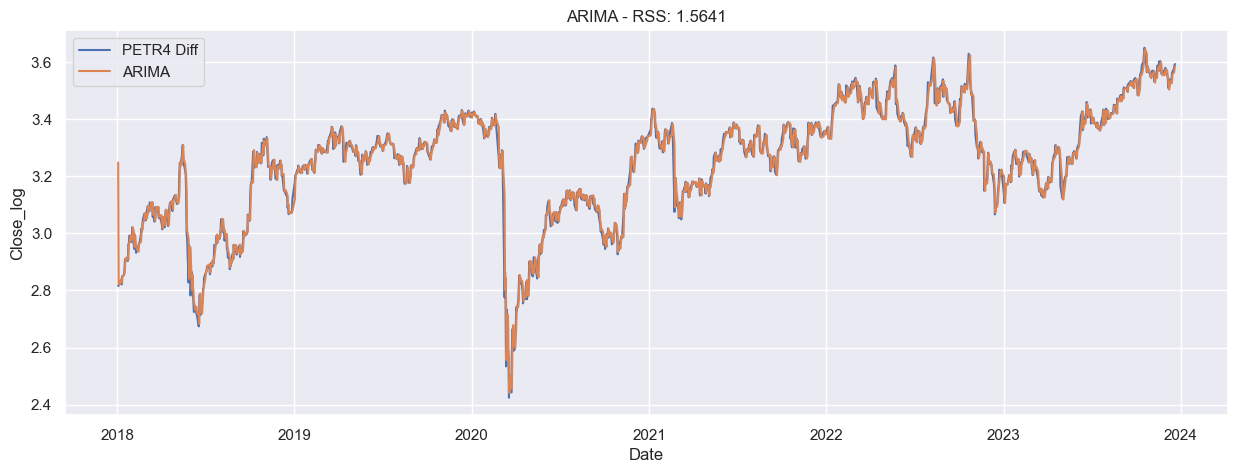

In [31]:
df_arima_pd = df_arima.to_pandas().set_index('Date')

model_arima = ARIMA(df_arima_pd['Close_log'], order=(2, 0, 2))
results_arima = model_arima.fit()

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_arima_pd, x="Date", y="Close_log", label="PETR4 Diff");
sns.lineplot(data=df_arima_pd, x="Date", y=results_arima.fittedvalues, label="ARIMA");

plt.title('ARIMA - RSS: %.4f'% sum((results_arima.fittedvalues-df_arima_pd['Close_log'])**2))

In [32]:
pred = results_arima.fittedvalues
pred.index = df_arima_pd.index

#pred_values = df_arima_pd['Close_log'].iloc[0] + np.cumsum(pred)

mape = mean_absolute_error(df_arima_pd['Close'], np.exp(pred))

print(f'MAPE: {mape:.2%}')

MAPE: 51.05%


## Modelo Prophet

O Prophet é um procedimento para previsão de séries temporais baseado em um modelo aditivo em que as tendências não lineares são ajustadas com sazonalidade anual, semanal e diária, além de efeitos de feriados. Ele funciona melhor com séries temporais que têm fortes efeitos sazonais e várias temporadas de dados históricos. O Prophet é robusto para dados ausentes e mudanças de tendência, e geralmente lida bem com outliers.

In [33]:
df_prophet = df_petr4.select(
    pl.col('Date').alias('ds'), 
    pl.col('Close').alias('y')
).to_pandas()

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d').dt.date

df_prophet.head()

,ds,y
0,2018-01-02,16.549999
1,2018-01-03,16.700001
2,2018-01-04,16.730000
3,2018-01-05,16.830000
4,2018-01-08,17.030001


In [34]:
days_test = 90

train_data = df_prophet[:-days_test]
test_data = df_prophet[-days_test:]

In [35]:
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_data)

df_future = model_prophet.make_future_dataframe(periods=90, freq='D')
pred = model_prophet.predict(df_future)
pred.head()

08:16:08 - cmdstanpy - INFO - Chain [1] start processing
08:16:08 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,16.805732,14.577665,21.846736,16.805732,16.805732,1.548390,1.548390,1.548390,1.42908,...,0.065608,0.065608,0.065608,0.053702,0.053702,0.053702,0.0,0.0,0.0,18.354121
1,2018-01-03,16.821791,14.958595,22.184212,16.821791,16.821791,1.653598,1.653598,1.653598,1.42908,...,0.091180,0.091180,0.091180,0.133338,0.133338,0.133338,0.0,0.0,0.0,18.475389
2,2018-01-04,16.837851,14.938581,22.193908,16.837851,16.837851,1.731308,1.731308,1.731308,1.42908,...,0.084658,0.084658,0.084658,0.217570,0.217570,0.217570,0.0,0.0,0.0,18.569159
3,2018-01-05,16.853910,15.160162,22.177056,16.853910,16.853910,1.760060,1.760060,1.760060,1.42908,...,0.025792,0.025792,0.025792,0.305189,0.305189,0.305189,0.0,0.0,0.0,18.613971
4,2018-01-08,16.902089,15.633000,22.511797,16.902089,16.902089,2.095181,2.095181,2.095181,1.42908,...,0.090032,0.090032,0.090032,0.576069,0.576069,0.576069,0.0,0.0,0.0,18.997270


/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


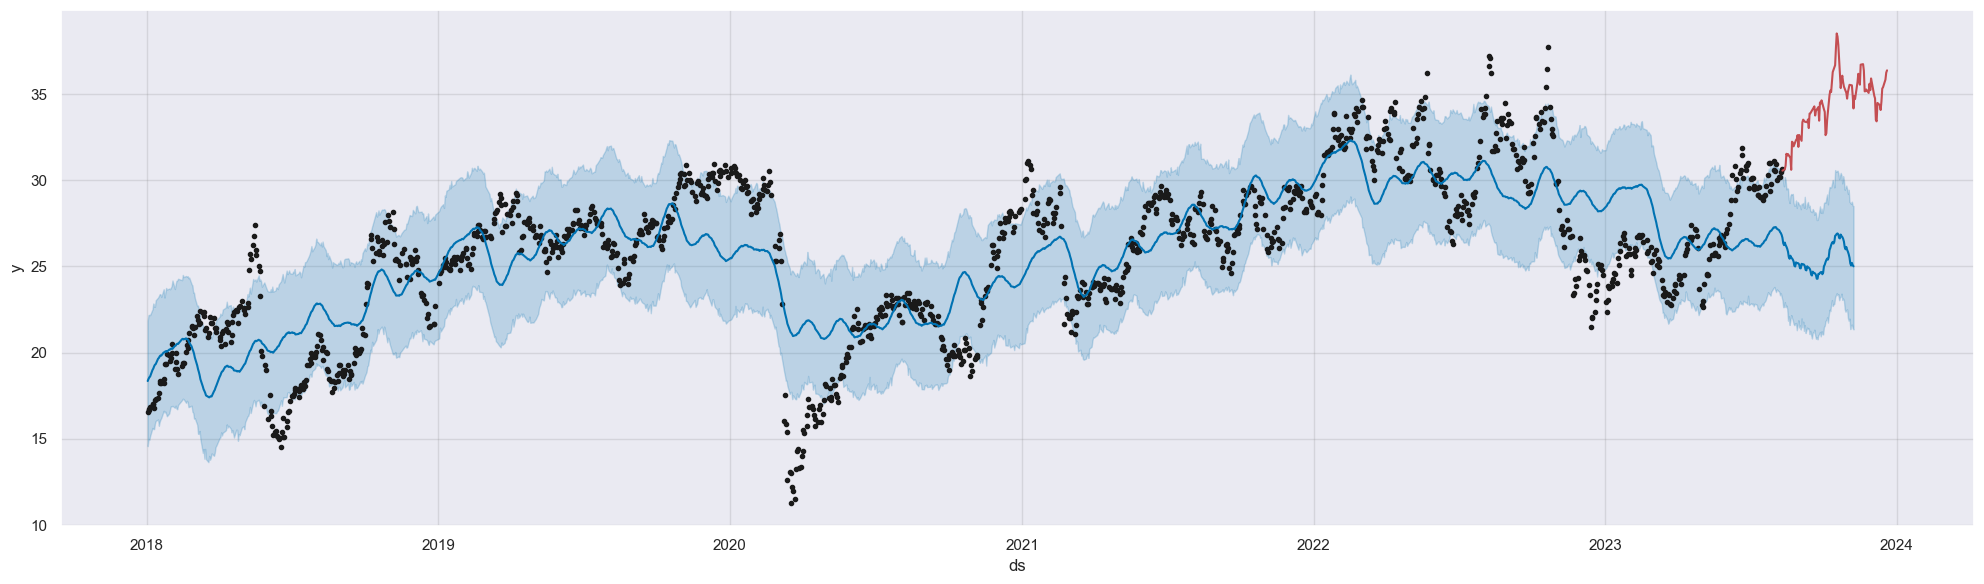

In [36]:
model_prophet.plot(pred, figsize=(20, 6));
plt.plot(test_data['ds'], test_data['y'], 'r');

/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/zfab/repos/postech/.venv/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead 

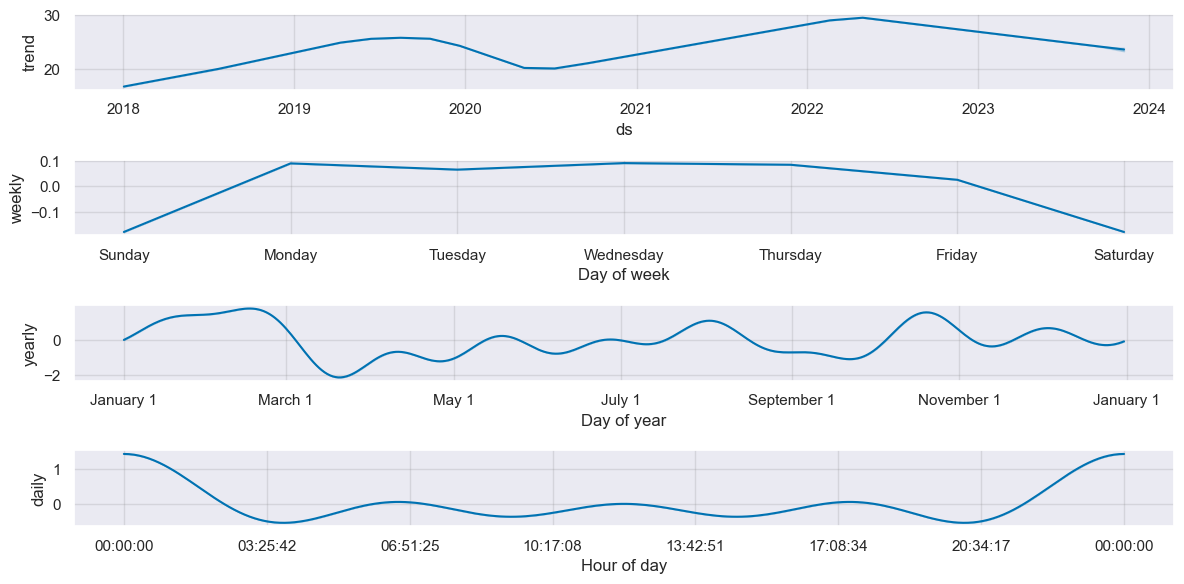

In [37]:
model_prophet.plot_components(pred, figsize=(12, 6));

In [38]:
pred_cols = ['ds', 'yhat']
true_cols = ['ds', 'y']

pred_df = pred[pred_cols].copy()
pred_df['ds'] = pd.to_datetime(pred_df['ds'], format='%Y-%m-%d').dt.date
true_df = train_data[true_cols].copy()
true_df['ds'] = pd.to_datetime(true_df['ds'], format='%Y-%m-%d').dt.date

result = pd.merge(pred_df, true_df, on='ds', how='inner')

mape = mean_absolute_error(result['y'], result['yhat'])

print(f'MAPE: {mape:.2%}')


MAPE: 224.32%


## Modelo LSTM

In [39]:
df_lstm = df_petr4.select(
    pl.col('Date'), 
    pl.col('Close')
)

df_lstm.head()

Date,Close
datetime[ns],f64
2018-01-02 00:00:00,16.549999
2018-01-03 00:00:00,16.700001
2018-01-04 00:00:00,16.73
2018-01-05 00:00:00,16.83
2018-01-08 00:00:00,17.030001


In [40]:
close_data = df_lstm['Close'].to_numpy().reshape(-1, 1)

In [41]:
mms = MinMaxScaler()
close_data = mms.fit_transform(close_data)

In [42]:
split_percent = .8
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df_lstm['Date'][:split]
date_test = df_lstm['Date'][split:]

In [43]:
look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [44]:
np.random.seed(42)

model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(look_back, 1)))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model_lstm.fit(train_generator, epochs=num_epochs, verbose=1)

2023-12-27 08:16:09.580145: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-27 08:16:09.580175: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-27 08:16:09.580186: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-27 08:16:09.580223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-27 08:16:09.580240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2023-12-27 08:16:10.286687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 8s 117ms/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 2/20
59/59 [==============================] - 7s 113ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 3/20
59/59 [==============================] - 7s 113ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/20
59/59 [==============================] - 7s 114ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 5/20
59/59 [==============================] - 7s 115ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 6/20
59/59 [==============================] - 7s 114ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 7/20
59/59 [==============================] - 7s 124ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 8/20
59/59 [==============================] - 7s 123ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 9/20
59/59 [==============================] - 7s 113ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 10/20
59/59 [==

In [45]:
mse = model_lstm.evaluate(test_generator, verbose=1)
print(f'MSE: {mse[0]}')

287/287 [==============================] - 7s 22ms/step - loss: 0.0018 - mean_squared_error: 0.0018
MSE: 0.0018211916321888566


In [46]:
test_predict = model_lstm.predict(test_generator)

test_predict_inv = mms.inverse_transform(test_predict.reshape(-1, 1))
test_actual_inv = mms.inverse_transform(np.array(close_test).reshape(-1, 1))

test_actual_inv = test_actual_inv[:len(test_predict_inv)]

mape = np.mean(np.abs(test_actual_inv - test_predict_inv)/np.abs(test_actual_inv))

print(f'MAPE: {mape:.2%}')

287/287 [==============================] - 6s 20ms/step
MAPE: 5.92%


In [47]:
rmse = np.sqrt(mse[0])
print(f'RMSE: {rmse}')

RMSE: 0.04267542187476132


In [48]:
pred = model_lstm.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
pred = pred.reshape((-1))

trace_1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Dados de treino'
)

trace_2 = go.Scatter(
    x = date_test,
    y = pred,
    mode = 'lines',
    name = 'Predição'
)

trace_3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Dados de teste'
)

layout = go.Layout(
    title = 'Predição de preços de ações',
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento (R$)"}
)

287/287 [==============================] - 6s 20ms/step


In [49]:
fig = go.Figure(data=[trace_1, trace_2, trace_3], layout=layout)
fig.show()